Aviso de AI

Parte del desarrollo de este proyecto fue asistida por herramientas de inteligencia artificial, específicamente ChatGPT (modelo GPT-5, OpenAI, 2025).

La IA se utilizó para apoyar parcialmente en la creación del agente estratégico, orientar en la depuración del modelo, refinar la forma de calcular métricas, y asistir en ajustes relacionados con el flujo de episodios y la estructura general de la simulación. También se empleó para aclarar conceptos y resolver errores durante el desarrollo.

Todo el contenido fue posteriormente verificado y adaptado manualmente, asegurando su coherencia, funcionamiento correcto y cumplimiento de los requerimientos de la tarea.

OpenAI. (2025). ChatGPT (versión GPT-5). Recuperado de https://chat.openai.com/

In [9]:
%pip install mesa==2.1.1   # instalamos la versión específica de Mesa para el modelo
%pip install matplotlib    # por si el entorno no tiene matplotlib

import random               # random básico de Python
import numpy as np          # numpy para manejar grids y arreglos
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation  # para animar la simulación paso a paso
from mesa import Agent, Model             # clases base de Mesa
from mesa.space import MultiGrid          # grid 2D donde vive el modelo
from mesa.time import RandomActivation    # scheduler que activa agentes en orden aleatorio
from mesa.datacollection import DataCollector  # para guardar estadísticas de la simulación

# Forzamos que las animaciones se muestren como HTML/JS en el notebook (no solo imagen estática)
plt.rcParams["animation.html"] = "jshtml"

# Permitimos animaciones grandes sin que las corte el límite por defecto
matplotlib.rcParams['animation.embed_limit'] = 2**128


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from mesa import Agent


class SimpsonAgentStrategic(Agent):
    """
    Agente estratégico usando capas:
    - hazard_grid: EMPTY / SMOKE / FIRE
    - victim_grid: True/False
    - NO entra en casillas con FIRE.
    - Puede apagar FIRE/SMOKE en su casilla o adyacentes ortogonales.
    - Puede cargar víctimas en su casilla y dejarlas en la ambulancia.

    El modelo le da:
    - role: "extinguisher" o "rescuer"
    """

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

        self.role = "rescuer"          # rol inicial por defecto (el modelo lo puede cambiar)

        self.carrying_victim = False   # si está cargando una víctima o no

        # plan de alto nivel (a dónde quiere ir)
        self.current_target = None     # celda objetivo (x, y)
        self.current_path = []         # ruta planeada con A* (lista de celdas)

        self.base_ap = 4               # puntos de acción por turno

        # contadores de estadísticas
        self.victims_picked = 0
        self.victims_rescued = 0
        self.fires_extinguished = 0
        self.smokes_extinguished = 0
        self.doors_opened = 0
        self.action_points = 0         # AP totales gastados

    # =====================
    #  LOOP DEL TURNO
    # =====================
    def step(self):
        """Turno del agente: decide objetivo, planea ruta y gasta AP siguiendo el plan."""
        if getattr(self.model, "game_over", False):  # si ya terminó el juego, no hace nada
            return

        ap = self.base_ap
        self.handle_victims()  # por si empieza encima de víctima o ambulancia

        # límite de iteraciones para evitar loops raros dentro del mismo turno
        max_iters = self.base_ap * 4

        for _ in range(max_iters):
            if ap <= 0:
                break

            # --- 1) modo "llevar a la ambulancia" si ya trae víctima ---
            if self.carrying_victim and self.pos != self.model.ambulance_pos:
                # objetivo fijo = ambulancia
                if self.current_target != self.model.ambulance_pos:
                    self.current_target = self.model.ambulance_pos
                    self.current_path = []
                    self.plan_path_to_target()
            else:
                # --- 2) modo normal (extinguisher / rescuer) ---
                # si no tengo target o ya no tiene sentido, busco uno nuevo
                if (not self.current_target) or (not self.is_target_still_valid()):
                    self.plan_new_target()

            # si aun así no tengo objetivo, intento apagar lo que haya cerca y paro
            if not self.current_target:
                ap = self.try_local_actions(ap)
                break

            # necesito una ruta hacia el target
            if not self.current_path:
                self.plan_path_to_target()

            # si el objetivo es mi propia casilla, no hay ruta,
            # entonces actuamos localmente en lugar de desecharlo de golpe.
            if not self.current_path:
                if self.current_target and self.pos == self.current_target:
                    ap = self.try_local_actions(ap)
                    self.current_target = None
                    self.current_path = []
                    continue
                # si de plano no hay ruta, suelto el objetivo
                self.current_target = None
                continue

            # intento moverme al siguiente paso de la ruta
            next_pos = self.current_path[0]
            ap_before = ap
            ap = self.move_towards(next_pos, ap)

            if ap == ap_before:
                # no me pude mover (pared, fuego, costo alto, etc.), reseteo objetivo
                self.current_path = []
                self.current_target = None
                continue

            # avance exitoso: quito el primer paso de la ruta
            self.current_path.pop(0)
            self.handle_victims()  # por si pisé víctima o ambulancia

            # si llegué al objetivo, intento apagar/cargar y reseteo objetivo
            if self.current_target and self.pos == self.current_target:
                ap = self.try_local_actions(ap)
                self.current_target = None
                self.current_path = []

    # =====================
    #  OBJETIVOS
    # =====================
    def is_target_still_valid(self):
        """Chequea si el target sigue teniendo sentido (todavía hay fuego/víctima y no está tomado)."""
        if self.current_target is None:
            return False

        x, y = self.current_target
        if not (0 <= x < self.model.width and 0 <= y < self.model.height):
            return False

        # si otro agente ya se adueñó del mismo objetivo, lo soltamos
        if hasattr(self.model, "is_target_taken_by_other"):
            if self.model.is_target_taken_by_other((x, y), self.unique_id):
                return False

        hazard = self.model.hazard_grid[x, y]
        has_victim = self.model.victim_grid[x, y]

        # extinguisher sólo se queda con targets donde todavía hay fuego o humo
        if self.role == "extinguisher":
            return hazard in (self.model.FIRE, self.model.SMOKE)
        # rescuer sólo se queda con targets donde todavía hay víctima (y no está cargando ya)
        elif self.role == "rescuer":
            return has_victim

        return False

    def plan_new_target(self):
        """Busca un nuevo objetivo con BFS (según el rol) y lo marca como reclamado."""
        self.current_target = None
        self.current_path = []

        target = self._bfs_find_target()
        if target is not None:
            self.current_target = target
            # avisamos al modelo para que otros agentes no elijan el mismo target
            if hasattr(self.model, "claim_target"):
                self.model.claim_target(target, self.unique_id)

    def _bfs_find_target(self):
        """
        BFS sobre el grid buscando:
        - extinguisher: celdas con FIRE o SMOKE
        - rescuer: celdas con victim_grid[x,y] == True
        Evita paredes y respeta edges del modelo.
        """
        start = self.pos

        visited = set([start])
        queue = [start]

        while queue:
            x, y = queue.pop(0)
            pos = (x, y)

            hazard = self.model.hazard_grid[x, y]
            has_victim = self.model.victim_grid[x, y]

            # esta celda puede ser objetivo?
            is_candidate = False
            if self.role == "extinguisher":
                if hazard in (self.model.FIRE, self.model.SMOKE) and not self._target_taken_by_other(pos):
                    is_candidate = True
            elif self.role == "rescuer" and not self.carrying_victim:
                if has_victim and not self._target_taken_by_other(pos):
                    is_candidate = True

            if is_candidate:
                # Aseguramos que realmente se puede llegar con A*
                if hasattr(self.model, "astar_path"):
                    path = self.model.astar_path(start, pos)
                else:
                    path = None

                if path and len(path) > 0:
                    return pos
                # si no hay ruta, seguimos buscando otra celda

            # expandimos BFS a vecinos ortogonales
            for nx, ny in ((x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)):
                if (nx, ny) in visited:
                    continue
                if not (0 <= nx < self.model.width and 0 <= ny < self.model.height):
                    continue

                edge_type = self.model.edges.get(((x, y), (nx, ny)), "empty")
                if edge_type == "wall":  # paredes bloquean el BFS
                    continue

                visited.add((nx, ny))
                queue.append((nx, ny))

        return None  # no encontró nada útil

    def _target_taken_by_other(self, pos):
        """Helper para preguntar al modelo si otro agente ya tiene este target."""
        if hasattr(self.model, "is_target_taken_by_other"):
            return self.model.is_target_taken_by_other(pos, self.unique_id)
        return False

    # =====================
    #  RUTA (A*)
    # =====================
    def plan_path_to_target(self):
        """Planea la ruta con A* desde la posición actual hasta current_target."""
        if self.current_target is None:
            self.current_path = []
            return

        if not hasattr(self.model, "astar_path"):
            self.current_path = []
            return

        start = self.pos
        goal = self.current_target
        path = self.model.astar_path(start, goal)

        if path is None:
            self.current_path = []
        else:
            # si A* incluye el start como primer nodo, lo removemos de la ruta
            if path and path[0] == start:
                path = path[1:]
            self.current_path = path

    # =====================
    #  MOVIMIENTO
    # =====================
    def move_towards(self, next_pos, ap):
        """
        Intenta moverse a next_pos:
        - no entra a FIRE
        - walls bloquean
        - door_closed se puede abrir (1 AP) y luego moverse
        - costo del movimiento: 1 sin víctima, 2 cargando víctima
        """
        if ap <= 0:
            return ap

        x, y = self.pos
        nx, ny = next_pos

        if not (0 <= nx < self.model.width and 0 <= ny < self.model.height):
            return ap

        edge_type = self.model.edges.get(((x, y), (nx, ny)), "empty")
        if edge_type == "wall":
            return ap  # no atraviesa paredes

        hazard = self.model.hazard_grid[nx, ny]

        # prohibido entrar a fuego
        if hazard == self.model.FIRE:
            return ap

        move_cost = 2 if self.carrying_victim else 1
        door_cost = 1 if edge_type == "door_closed" else 0
        total_cost = move_cost + door_cost

        if total_cost > ap:
            return ap  # no tiene suficientes AP para todo

        # primero abre la puerta si está cerrada
        if edge_type == "door_closed":
            if hasattr(self.model, "set_edge"):
                self.model.set_edge((x, y), (nx, ny), "door_open")
            self.doors_opened += 1
            self.action_points += 1
            ap -= 1

        # luego se mueve a la siguiente celda
        self.model.grid.move_agent(self, (nx, ny))
        self.action_points += move_cost
        ap -= move_cost

        return ap

    # =====================
    #  ACCIONES LOCALES (APAGAR)
    # =====================
    def try_local_actions(self, ap):
        """
        Intenta apagar en su casilla o vecinas ortogonales:
        - SMOKE: 1 AP → EMPTY
        - FIRE: 2 AP → EMPTY
        - FIRE con solo 1 AP: lo baja a SMOKE
        """
        if ap <= 0:
            return ap

        x, y = self.pos
        positions = [(x, y)] + self.model.grid.get_neighborhood(
            (x, y), moore=False, include_center=False
        )

        for tx, ty in positions:
            if not (0 <= tx < self.model.width and 0 <= ty < self.model.height):
                continue

            hazard = self.model.hazard_grid[tx, ty]

            # limpiar humo
            if hazard == self.model.SMOKE and ap >= 1:
                self.model.hazard_grid[tx, ty] = self.model.EMPTY
                self.smokes_extinguished += 1
                self.action_points += 1
                return ap - 1

            # apagar fuego o bajarlo a humo
            elif hazard == self.model.FIRE:
                if ap >= 2:
                    self.model.hazard_grid[tx, ty] = self.model.EMPTY
                    self.fires_extinguished += 1
                    self.action_points += 2
                    return ap - 2
                elif ap == 1:
                    self.model.hazard_grid[tx, ty] = self.model.SMOKE
                    self.smokes_extinguished += 1
                    self.action_points += 1
                    return ap - 1

        return ap  # no encontró nada que apagar

    # =====================
    #  VÍCTIMAS (victim_grid)
    # =====================
    def handle_victims(self):
        """
        - Si hay víctima en victim_grid[x,y] y no cargo a nadie → la recoge.
        - Si cargo víctima y estoy en ambulancia → la rescato y el modelo respawnea otra.
        """
        x, y = self.pos

        # recoger víctima en la casilla actual
        if self.model.victim_grid[x, y] and not self.carrying_victim:
            self.carrying_victim = True
            self.model.victim_grid[x, y] = False
            self.victims_picked += 1

        # dejar víctima si estoy en la ambulancia
        if self.carrying_victim and (x, y) == self.model.ambulance_pos:
            self.carrying_victim = False
            self.victims_rescued += 1

            # avisamos al modelo para actualizar sus contadores y respawnear
            if hasattr(self.model, "victims_rescued_total"):
                self.model.victims_rescued_total += 1
            if hasattr(self.model, "victims_update"):
                self.model.victims_update(1)

In [11]:
import random
import numpy as np
from mesa import Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import heapq


class SimpsonStrategicModel(Model):
    """
    Modelo estratégico tipo Flashpoint:
    - Usa capas (hazard_grid, victim_grid, static_grid).
    - Maneja bordes (edges) con paredes, puertas y vacío.
    - Incluye A* para pathfinding y reparto de roles globales
      (extinguisher / rescuer) según el nivel de fuego.
    """

    # Códigos para el colormap / visualización
    EMPTY = 0
    FIRE = 1
    SMOKE = 2
    VICTIM = 3
    DOOR_CLOSED = 4
    DOOR_OPEN = 5
    AMBULANCE = 6
    FIREFIGHTER = 7
    VICTIM_SMOKE = 8  # víctima en celda con humo (solo para viz)

    def __init__(
        self,
        width=10,
        height=10,
        num_firefighters=6,
        num_fires=10,
        num_smokes=0,
        num_victims=4,
        num_doors=11,
        num_walls=24,
        wall_hp=2,
        seed=None,

        # ---- layout manual (MISMO que el random) ----
        use_random_edges=True,
        walls=[
            ((0,2), (1,2), 2),
            ((0,3), (1,3), 2),
            ((0,4), (1,4), 2),
            ((0,5), (1,5), 2),
            ((0,6), (1,6), 2),
            ((0,7), (1,7), 2),
            ((1,8), (1,7), 2),
            ((2,8), (2,7), 2),
            ((4,8), (4,7), 2),
            ((5,8), (5,7), 2),
            ((5,8), (6,8), 2),
            ((6,9), (6,8), 2),
            ((7,9), (7,8), 2),
            ((9,8), (8,8), 2),
            ((9,7), (8,7), 2),
            ((9,6), (8,6), 2),
            ((9,5), (8,5), 2),
            ((9,3), (8,3), 2),
            ((9,2), (8,2), 2),
            ((8,2), (8,1), 2),
            ((7,2), (7,1), 2),
            ((7,1), (6,1), 2),
            ((6,1), (6,0), 2),
            ((5,1), (5,0), 2),
            ((4,1), (4,0), 2),
            ((3,1), (3,0), 2),
            ((3,1), (2,1), 2),
            ((1,2), (1,1), 2), # Aquí acaban las paredes exteriores
            ((1,5), (1,4), 2),
            ((3,5), (3,4), 2),
            ((4,5), (4,4), 2),
            ((6,5), (6,4), 2),
            ((8,5), (8,4), 2),
            ((3,7), (2,7), 2),
            ((3,5), (2,5), 2),
            ((3,4), (2,4), 2),
            ((3,3), (2,3), 2),
            ((3,2), (2,2), 2),
            ((4,7), (3,7), 2),
            ((4,5), (3,5), 2),
            ((6,8), (5,8), 2),
            ((6,7), (5,7), 2),
            ((6,6), (5,6), 2),
            ((6,5), (5,5), 2),
            ((6,3), (5,3), 2),
            ((6,2), (5,2), 2),
            ((6,1), (5,1), 2),
            ((7,3), (6,3), 2),
            ((7,2), (6,2), 2),
            ((8,3), (8,4), 2),
        ],       
        doors_closed=[
            ((3,8), (3,7)),
            ((8,9), (8,8)),
            ((9,4), (8,4)),
            ((2,2), (2,1)), # Aquí acaban las puertas exteriores
            ((2,5), (2,4)),
            ((5,5), (5,4)),
            ((7,5), (7,4)),
            ((3,6), (2,6)),
            ((4,6), (3,6)),
            ((6,4), (5,4)),
            ((7,3), (7,4)),
        ], 
        doors_open=None,  
    ):
        super().__init__()
        # seed para reproducibilidad
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            self.random.seed(seed)

        self.width = width
        self.height = height

        # grid de Mesa (para agentes)
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)

        # --- CAPAS (representación del entorno) ---
        self.hazard_grid = np.zeros((width, height), dtype=np.int8)   # 0 empty / 1 fire / 2 smoke
        self.victim_grid = np.zeros((width, height), dtype=bool)      # víctimas pueden coexistir con smoke
        self.static_grid = np.zeros((width, height), dtype=np.int8)   # ambulancia, etc.

        # posición fija de la ambulancia
        self.ambulance_pos = (0, 0)
        self.static_grid[self.ambulance_pos] = self.AMBULANCE

        # --- EDGES (paredes / puertas / vacío) ---
        self.edges = {}
        self.wall_hp_default = wall_hp
        self.wall_hp = {}  # key=(sorted(pos_a,pos_b)) -> int hp (vida de la pared)

        self.wall_damaged_total = 0  # contador de daño acumulado a paredes

        # inicializamos todo como "empty"
        self._init_edges_empty()

        # Si se pasan listas manuales, usamos manual por default
        if walls or doors_closed or doors_open:
            use_random_edges = False

        if use_random_edges:
            # layout procedimental
            self._randomly_place_edges(num_walls, "wall", wall_hp=wall_hp)
            self._randomly_place_edges(num_doors, "door_closed")
        else:
            # layout fijo idéntico al modelo random
            self.apply_manual_edges(walls=walls, doors_closed=doors_closed, doors_open=doors_open)

        # celdas "dentro de la casa" según flood-fill
        self.inside_cells = self._compute_inside_cells()

        # colocación inicial de fuegos, humos y víctimas
        self._randomly_place_hazards(num_fires, self.FIRE)
        self._randomly_place_hazards(num_smokes, self.SMOKE)
        self._randomly_place_victims(num_victims)

        # --- agentes estratégicos (usan SimpsonAgentStrategic) ---
        for i in range(num_firefighters):
            self._add_firefighter(i)

        # estado global del juego
        self.victims_rescued_total = 0
        self.victims_dead_total = 0
        self.game_over = False
        self.game_result = None

        # Grid combinado para visualización
        self.env_grid = self.get_base_visual_grid()

        # objetivos reclamados por agentes (para coordinar targets)
        self.claimed_targets = {}

        # DataCollector para stats de modelo y agentes
        self.datacollector = DataCollector(
            model_reporters={
                "total_victims_picked":      lambda m: sum(a.victims_picked for a in m.schedule.agents),
                "total_victims_rescued":     lambda m: sum(a.victims_rescued for a in m.schedule.agents),
                "total_fires_extinguished":  lambda m: sum(a.fires_extinguished for a in m.schedule.agents),
                "total_smokes_extinguished": lambda m: sum(a.smokes_extinguished for a in m.schedule.agents),
                "total_doors_opened":        lambda m: sum(a.doors_opened for a in m.schedule.agents),
                "total_action_points":       lambda m: sum(a.action_points for a in m.schedule.agents),
                "total_walls_broken":        lambda m: sum(getattr(a, "walls_broken", 0) for a in m.schedule.agents),
                "victims_rescued_total":     "victims_rescued_total",
                "victims_dead_total":        "victims_dead_total",
                "wall_damaged_total":        lambda m: m.wall_damaged_total,
            },
            agent_reporters={
                "victims_picked":      "victims_picked",
                "victims_rescued":     "victims_rescued",
                "fires_extinguished":  "fires_extinguished",
                "smokes_extinguished": "smokes_extinguished",
                "doors_opened":        "doors_opened",
                "action_points":       "action_points",
                "walls_broken":        lambda a: getattr(a, "walls_broken", 0),
                "role":                lambda a: getattr(a, "role", None),
            },
        )

    # -----------------------
    # Visual
    # -----------------------
    def sync_env_grid(self):
        """Actualiza el grid de visualización combinando capas."""
        self.env_grid = self.get_base_visual_grid()

    def get_base_visual_grid(self):
        """Construye una matriz de ints para pintar en imshow con colormap."""
        vis = np.zeros((self.width, self.height), dtype=np.int16)

        ax, ay = self.ambulance_pos
        vis[ax, ay] = self.AMBULANCE

        # fuego y humo
        vis[self.hazard_grid == self.SMOKE] = self.SMOKE
        vis[self.hazard_grid == self.FIRE] = self.FIRE

        # víctimas
        vmask = self.victim_grid
        vis[vmask] = self.VICTIM

        # víctimas en humo
        smoke_victim = (self.hazard_grid == self.SMOKE) & vmask
        vis[smoke_victim] = self.VICTIM_SMOKE

        # reforzamos fuego y ambulancia
        vis[self.hazard_grid == self.FIRE] = self.FIRE
        vis[ax, ay] = self.AMBULANCE
        return vis

    def get_visual_grid(self):
        """Devuelve el grid base pero con los bomberos pintados encima."""
        vis = self.get_base_visual_grid()
        for agent in self.schedule.agents:
            x, y = agent.pos
            vis[x, y] = self.FIREFIGHTER
        return vis

    # -----------------------
    # Edges / HP + MANUAL
    # -----------------------
    def edge_key(self, pos_a, pos_b):
        """Llave canónica para el dict de HP de paredes (ordenando las posiciones)."""
        return tuple(sorted([pos_a, pos_b]))

    def _assert_adjacent(self, a, b):
        """Valida que a y b sean vecinos ortogonales dentro del grid."""
        if abs(a[0]-b[0]) + abs(a[1]-b[1]) != 1:
            raise ValueError(f"Edge inválido (no son vecinos ortogonales): {a} <-> {b}")
        for (x, y) in (a, b):
            if not (0 <= x < self.width and 0 <= y < self.height):
                raise ValueError(f"Posición fuera del grid: {(x,y)}")

    def set_edge(self, pos_a, pos_b, edge_type):
        """Asigna un tipo de borde (wall / door_open / door_closed / empty) en ambos sentidos."""
        self.edges[(pos_a, pos_b)] = edge_type
        self.edges[(pos_b, pos_a)] = edge_type

        # si deja de ser pared, le quitamos su HP
        if edge_type != "wall":
            k = self.edge_key(pos_a, pos_b)
            if k in self.wall_hp:
                del self.wall_hp[k]

    def add_wall(self, a, b, hp=None):
        """Crea una pared entre a y b, con HP opcional."""
        self._assert_adjacent(a, b)
        self.set_edge(a, b, "wall")
        self.wall_hp[self.edge_key(a, b)] = int(self.wall_hp_default if hp is None else hp)

    def add_door_closed(self, a, b):
        """Crea una puerta cerrada entre a y b."""
        self._assert_adjacent(a, b)
        self.set_edge(a, b, "door_closed")

    def add_door_open(self, a, b):
        """Crea una puerta abierta entre a y b."""
        self._assert_adjacent(a, b)
        self.set_edge(a, b, "door_open")

    def apply_manual_edges(self, walls=None, doors_closed=None, doors_open=None):
        """Aplica listas manuales de paredes y puertas al diccionario de edges."""
        walls = walls or []
        doors_closed = doors_closed or []
        doors_open = doors_open or []

        for item in walls:
            # permite ((a,b)) sin hp o ((a,b,hp)) con hp explícita
            if len(item) == 2:
                a, b = item
                hp = None
            else:
                a, b, hp = item
            self.add_wall(a, b, hp=hp)

        for a, b in doors_closed:
            self.add_door_closed(a, b)

        for a, b in doors_open:
            self.add_door_open(a, b)

    def _init_edges_empty(self):
        """Inicializa todos los bordes posibles como 'empty' (sin pared ni puerta)."""
        for x in range(self.width):
            for y in range(self.height):
                from_pos = (x, y)
                # solo derecha y arriba para no duplicar
                neighbors = [(x + 1, y), (x, y + 1)]
                for nx, ny in neighbors:
                    if 0 <= nx < self.width and 0 <= ny < self.height:
                        to_pos = (nx, ny)
                        if (from_pos, to_pos) not in self.edges:
                            self.set_edge(from_pos, to_pos, "empty")

    def _randomly_place_edges(self, count, edge_type, wall_hp=None):
        """Coloca aleatoriamente 'count' bordes del tipo indicado (pared o puerta)."""
        all_pairs = []
        for x in range(self.width):
            for y in range(self.height):
                from_pos = (x, y)
                neighbors = [(x + 1, y), (x, y + 1)]
                for nx, ny in neighbors:
                    if 0 <= nx < self.width and 0 <= ny < self.height:
                        all_pairs.append((from_pos, (nx, ny)))

        self.random.shuffle(all_pairs)

        placed = 0
        for from_pos, to_pos in all_pairs:
            if placed >= count:
                break
            current = self.edges.get((from_pos, to_pos), "empty")
            if current == "empty":
                self.set_edge(from_pos, to_pos, edge_type)
                if edge_type == "wall":
                    hp_val = self.wall_hp_default if wall_hp is None else wall_hp
                    self.wall_hp[self.edge_key(from_pos, to_pos)] = int(hp_val)
                placed += 1

    def can_move(self, from_pos, to_pos):
        """Chequea si es posible moverse de from_pos a to_pos (1 paso ortogonal, sin pared/puerta cerrada)."""
        fx, fy = from_pos
        tx, ty = to_pos

        # deben ser vecinos ortogonales
        if abs(tx - fx) + abs(ty - fy) != 1:
            return False

        # dentro del grid
        if tx < 0 or tx >= self.width or ty < 0 or ty >= self.height:
            return False

        # checamos el tipo de borde
        edge_type = self.edges.get((from_pos, to_pos), "empty")
        if edge_type in ("wall", "door_closed"):
            return False
        return True

    def damage_wall(self, from_pos, to_pos, dmg=1):
        """Aplica daño a una pared; si HP llega a 0, se destruye (pasa a empty)."""
        if self.edges.get((from_pos, to_pos), "empty") != "wall":
            return False

        k = self.edge_key(from_pos, to_pos)
        if k not in self.wall_hp:
            self.wall_hp[k] = self.wall_hp_default

        self.wall_damaged_total += int(dmg)
        self.wall_hp[k] -= int(dmg)

        if self.wall_hp[k] <= 0:
            self.set_edge(from_pos, to_pos, "empty")
            return True
        return False
    

    def _compute_inside_cells(self):
        """
        Marca qué celdas son 'outside' (conectadas a borde sin cruzar paredes/puertas).
        Las demás se consideran 'inside' (interior del edificio).
        """
        from collections import deque

        outside = set()
        d = deque()

        # inicializamos borde externo como outside
        for x in range(self.width):
            for y in range(self.height):
                if x == 0 or x == self.width - 1 or y == 0 or y == self.height - 1:
                    outside.add((x, y))
                    d.append((x, y))

        # flood-fill respetando walls/doors_closed
        while d:
            x, y = d.popleft()

            neighbors = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]
            for nx, ny in neighbors:
                if not (0 <= nx < self.width and 0 <= ny < self.height):
                    continue
                if (nx, ny) in outside:
                    continue

                edge_type = self.edges.get(((x, y), (nx, ny)), "empty")
                if edge_type in ("wall", "door_closed"):
                    continue

                outside.add((nx, ny))
                d.append((nx, ny))

        inside = [
            (x, y)
            for x in range(self.width)
            for y in range(self.height)
            if (x, y) not in outside
        ]

        return inside

    # -----------------------
    # Colocación inicial (capas)
    # -----------------------
    def _randomly_place_hazards(self, count, code):
        """Coloca 'count' celdas con hazard (FIRE/SMOKE) solo en inside_cells."""
        all_cells = list(self.inside_cells)
        self.random.shuffle(all_cells)

        placed = 0
        for x, y in all_cells:
            if placed >= count:
                break
            if (x, y) == self.ambulance_pos:
                continue
            if self.hazard_grid[x, y] == self.EMPTY:
                self.hazard_grid[x, y] = code
                placed += 1

    def _randomly_place_victims(self, count):
        """Coloca 'count' víctimas en celdas interiores, sin fuego y sin repetir."""
        all_cells = list(self.inside_cells)
        self.random.shuffle(all_cells)

        placed = 0
        for x, y in all_cells:
            if placed >= count:
                break
            if (x, y) == self.ambulance_pos:
                continue
            if self.hazard_grid[x, y] == self.FIRE:
                continue
            if not self.victim_grid[x, y]:
                self.victim_grid[x, y] = True
                placed += 1

    def _add_firefighter(self, i):
        """
        Coloca un SimpsonAgentStrategic en una de las celdas de spawn
        (mismas que en el modelo random).
        """
        from math import inf  # por si algún día se usa, aquí no es crítico

        all_cells = [
            (2,9), (3,9), (4,9),
            (0,0), (1,0), (2,0),
            (9,3), (9,4), (9,5),
        ]  
    
        for x, y in all_cells:
            if (x, y) == self.ambulance_pos:
                continue
            if self.grid.is_cell_empty((x, y)) and self.hazard_grid[x, y] == self.EMPTY and not self.victim_grid[x, y]:
                # aquí se asume que SimpsonAgentStrategic ya está importado
                agent = SimpsonAgentStrategic(self.next_id(), self)
                self.grid.place_agent(agent, (x, y))
                self.schedule.add(agent)
                break

    # -----------------------
    # Víctimas / fuego / humo
    # -----------------------
    def victims_update(self, num_victims=1):
        """Respawnea víctimas nuevas (num_victims) en celdas interiores seguras."""
        all_cells = list(self.inside_cells)
        self.random.shuffle(all_cells)

        placed = 0
        for x, y in all_cells:
            if placed >= num_victims:
                break
            if (x, y) == self.ambulance_pos:
                continue
            if self.hazard_grid[x, y] == self.FIRE:
                continue
            if not self.victim_grid[x, y]:
                self.victim_grid[x, y] = True
                placed += 1

    def apply_fire_to_cell(self, x, y):
        """Aplica la lógica de fuego a una celda: mata víctima y la reemplaza, y marca FIRE."""
        if (x, y) == self.ambulance_pos:
            return

        # si había víctima, muere y se respawnea otra
        if self.victim_grid[x, y]:
            self.victim_grid[x, y] = False
            self.victims_dead_total += 1
            self.victims_update(1)

        # la celda pasa a fuego si estaba vacía o con humo
        if self.hazard_grid[x, y] in (self.EMPTY, self.SMOKE):
            self.hazard_grid[x, y] = self.FIRE

    def explosion(self, x, y, exploded=None):
        """Propaga una explosión desde (x,y): daña paredes, destruye puertas, encadena fuegos."""
        if exploded is None:
            exploded = set()
        if (x, y) in exploded:
            return
        exploded.add((x, y))

        for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]:
            nx, ny = x + dx, y + dy
            if not (0 <= nx < self.width and 0 <= ny < self.height):
                continue

            edge_type = self.edges.get(((x, y), (nx, ny)), "empty")

            # pared: se daña; si NO se rompe, bloquea el fuego
            if edge_type == "wall":
                if not self.damage_wall((x, y), (nx, ny), dmg=1):
                    continue

            # puertas: se destruyen (cerradas o abiertas)
            if edge_type in ("door_closed", "door_open"):
                self.set_edge((x, y), (nx, ny), "empty")

            had_fire = (self.hazard_grid[nx, ny] == self.FIRE)
            self.apply_fire_to_cell(nx, ny)

            # si ya había fuego, puede encadenar otra explosión
            if had_fire and (nx, ny) not in exploded:
                self.explosion(nx, ny, exploded)

    def smoke_adjacent_to_fire(self, x, y):
        """Si (x,y) tiene humo y está pegado a fuego (sin pared), se convierte en fuego."""
        for dx, dy in [(1,0), (-1,0), (0,1), (0,-1)]:
            nx, ny = x + dx, y + dy
            if not (0 <= nx < self.width and 0 <= ny < self.height):
                continue
            if self.hazard_grid[nx, ny] == self.FIRE:
                edge_type = self.edges.get(((x, y), (nx, ny)), "empty")
                if edge_type == "wall":
                    continue
                self.apply_fire_to_cell(x, y)
                return True
        return False

    def new_fire(self):
        """
        Lógica de nueva carta de fuego:
        - EMPTY -> SMOKE
        - SMOKE -> FIRE
        - FIRE -> explosión
        Recorre inside_cells en orden aleatorio y aplica la primera regla que corresponda.
        """
        all_cells = list(self.inside_cells)
        self.random.shuffle(all_cells)

        for x, y in all_cells:
            if (x, y) == self.ambulance_pos:
                continue

            h = self.hazard_grid[x, y]

            if h == self.EMPTY:
                self.hazard_grid[x, y] = self.SMOKE
                self.smoke_adjacent_to_fire(x, y)
                break
            elif h == self.SMOKE:
                self.apply_fire_to_cell(x, y)
                break
            elif h == self.FIRE:
                self.explosion(x, y)
                break

    # -----------------------
    # ROLES GLOBALES (2 o 4 extinguisher)
    # -----------------------
    def assign_roles_global(self):
        """
        Asigna roles a TODOS los bomberos según la cantidad de fuego:
        - Si hay poco fuego (<= 4): 2 extinguisher, resto rescuer.
        - Si hay mucho fuego  (> 4): 4 extinguisher, resto rescuer.
        Si no hay fuego: todos rescuer.
        """
        agents = list(self.schedule.agents)
        total_fires = int(np.sum(self.hazard_grid == self.FIRE))

        if total_fires == 0:
            # todos a rescatar
            for a in agents:
                a.role = "rescuer"
            return

        FIRE_LOW = 4  # umbral que puedes ajustar

        if total_fires <= FIRE_LOW:
            num_extinguishers = min(2, len(agents))
        else:
            num_extinguishers = min(4, len(agents))

        # simple: los primeros N apagan, el resto rescata
        for idx, a in enumerate(agents):
            if idx < num_extinguishers:
                a.role = "extinguisher"
            else:
                a.role = "rescuer"

    # -----------------------
    # OBJETIVOS COMPARTIDOS
    # -----------------------
    def reset_claimed_targets(self):
        """Resetea el diccionario de objetivos reclamados (por turno)."""
        self.claimed_targets = {}

    def claim_target(self, pos, agent_id):
        """Marca pos como objetivo reclamado por agent_id."""
        self.claimed_targets[pos] = agent_id

    def is_target_taken_by_other(self, pos, agent_id):
        """Devuelve True si pos está reclamada por otro agente distinto a agent_id."""
        owner = self.claimed_targets.get(pos)
        return owner is not None and owner != agent_id

    # -----------------------
    # A* SOBRE CAPAS
    # -----------------------
    def astar_path(self, start, goal):
        """
        A* para el modelo estratégico:
        - No cruza walls.
        - Permite puertas (open/closed).
        - No entra a FIRE.
        - Limita el número de expansiones para evitar loops.
        """
        if start == goal:
            return [start]

        def heuristic(a, b):
            # distancia Manhattan
            return abs(a[0] - b[0]) + abs(a[1] - b[1])

        open_set = []
        heapq.heappush(open_set, (heuristic(start, goal), 0, start))
        came_from = {}
        g_score = {start: 0}

        max_expansions = 300  # límite de nodos explorados
        expansions = 0

        while open_set:
            expansions += 1
            if expansions > max_expansions:
                return None

            f, g, current = heapq.heappop(open_set)
            if current == goal:
                # reconstruir camino
                path = [current]
                while current in came_from:
                    current = came_from[current]
                    path.append(current)
                path.reverse()
                return path

            x, y = current
            for nx, ny in ((x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)):
                if not (0 <= nx < self.width and 0 <= ny < self.height):
                    continue

                edge_type = self.edges.get(((x, y), (nx, ny)), "empty")
                if edge_type == "wall":
                    continue

                # no entrar a fuego
                if self.hazard_grid[nx, ny] == self.FIRE:
                    continue

                neighbor = (nx, ny)
                tentative_g = g + 1

                if tentative_g < g_score.get(neighbor, float("inf")):
                    g_score[neighbor] = tentative_g
                    came_from[neighbor] = current
                    f_score = tentative_g + heuristic(neighbor, goal)
                    heapq.heappush(open_set, (f_score, tentative_g, neighbor))

        return None  # no se encontró ruta

    # -----------------------
    # Game loop
    # -----------------------
    def check_game_over(self):
        """Revisa condiciones de victoria/derrota y marca game_over + game_result."""
        if self.game_over:
            return

        # derrota: todo el edificio en llamas (salvo ambulancia)
        mask = np.ones((self.width, self.height), dtype=bool)
        ax, ay = self.ambulance_pos
        mask[ax, ay] = False
        if np.all(self.hazard_grid[mask] == self.FIRE):
            self.game_over = True
            self.game_result = "lose"
            print("Game Over: todo el edificio está en llamas.")
            return
        
        # derrota: demasiadas paredes dañadas
        if self.wall_damaged_total >= 24:
            self.game_over = True
            self.game_result = "lose"
            print("Game Over: perdiste por dañar demasiadas paredes.")
            return

        # victoria / derrota por víctimas
        if self.victims_rescued_total >= 7:
            self.game_over = True
            self.game_result = "win"
            print("Game Over: ganaste por rescatar suficientes víctimas.")
        elif self.victims_dead_total >= 4:
            self.game_over = True
            self.game_result = "lose"
            print("Game Over: perdiste por demasiadas víctimas muertas.")

    def step(self):
        """
        Un paso del modelo:
        - Asigna roles globales (según fuego).
        - Resetea objetivos compartidos y deja que cada agente los reclame.
        - Ejecuta step() de todos los agentes.
        - Aplica la carta de fuego (new_fire) y revisa condiciones de fin de juego.
        - Actualiza visual y DataCollector.
        """
        if self.game_over:
            return

        # roles globales según cantidad de fuego actual
        self.reset_claimed_targets()
        self.assign_roles_global()

        # agentes actúan (cada uno con BFS + A* + lógica de víctimas/fuego)
        self.schedule.step()

        # fuego / humo / explosiones
        self.new_fire()
        self.check_game_over()

        # actualización visual y recolección de stats
        self.sync_env_grid()
        self.datacollector.collect(self)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import LineCollection
from IPython.display import HTML, display

# Forzar que las animaciones se muestren como HTML/JS en Jupyter (no como GIF plano)
from matplotlib import rc
rc("animation", html="jshtml")

# Fallback por si no tienes 'colors' / 'cmap' definidos antes en el notebook
try:
    cmap
    colors
except NameError:
    from matplotlib.colors import ListedColormap
    # 0: blanco, 1: fuego, 2: humo, 3: víctima, 4–7: otros (puertas, ambulancia, etc.)
    colors = ["white", "red", "orange", "blue", "black", "gray", "green", "magenta"]
    cmap = ListedColormap(colors)


def _agents_list(model):
    """
    Devuelve la lista de agentes del modelo, compatible con:
    - Mesa 3.x: model.agents
    - Versiones viejas: model.schedule.agents
    """
    if hasattr(model, "agents"):
        return list(model.agents)
    if hasattr(model, "schedule"):
        return list(model.schedule.agents)
    return []


def edge_segments(model):
    """
    Convierte model.edges (info de bordes entre celdas) a segmentos de línea
    para dibujar encima del grid.

    Para cada borde horizontal / vertical:
    - Si es 'wall'        → va a la lista de paredes
    - Si es 'door_closed' → lista de puertas cerradas
    - Si es 'door_open'   → lista de puertas abiertas

    Retorna:
        walls, doors_closed, doors_open
    donde cada elemento es una lista de segmentos,
    y cada segmento es [(x1, y1), (x2, y2)] en coords de matplotlib.
    """
    walls, doors_closed, doors_open = [], [], []

    for x in range(model.width):
        for y in range(model.height):
            # borde entre (x,y) y (x+1,y) => línea vertical en x+0.5
            if x + 1 < model.width:
                t = model.edges.get(((x, y), (x + 1, y)), "empty")
                seg = [(x + 0.5, y - 0.5), (x + 0.5, y + 0.5)]
                if t == "wall":
                    walls.append(seg)
                elif t == "door_closed":
                    doors_closed.append(seg)
                elif t == "door_open":
                    doors_open.append(seg)

            # borde entre (x,y) y (x,y+1) => línea horizontal en y+0.5
            if y + 1 < model.height:
                t = model.edges.get(((x, y), (x, y + 1)), "empty")
                seg = [(x - 0.5, y + 0.5), (x + 0.5, y + 0.5)]
                if t == "wall":
                    walls.append(seg)
                elif t == "door_closed":
                    doors_closed.append(seg)
                elif t == "door_open":
                    doors_open.append(seg)

    return walls, doors_closed, doors_open


def run_one_game(seed, max_steps=500):
    """
    Corre una sola simulación estratégica con una seed dada.

    Parámetros:
        seed      : semilla del modelo
        max_steps : número máximo de pasos antes de cortar

    Regresa:
        (resultado, steps)
        donde resultado es model.game_result y steps el número de pasos usados.
    """
    model = SimpsonStrategicModel(
        width=10,
        height=10,
        num_firefighters=6,
        num_victims=4,
        seed=seed,
    )
    
    # loop principal del juego hasta que se acabe o lleguemos a max_steps
    while (not model.game_over) and (model.schedule.steps < max_steps):
        model.step()
    
    result = getattr(model, "game_result", None)
    steps = getattr(model.schedule, "steps", None)
    return result, steps


def run_many_games(n_games=50, base_seed=0, max_steps=500, verbose=False):
    """
    Corre n_games simulaciones, modificando la seed en cada una:
        seed_i = base_seed + i

    Parámetros:
        n_games   : cuántas partidas correr
        base_seed : seed base
        max_steps : máximo de pasos por partida
        verbose   : si True, imprime el resultado de cada juego

    Regresa:
        stats, results_list

        stats: diccionario con:
           - games        : número de juegos
           - wins         : cuántas victorias
           - losses       : cuántas derrotas
           - other        : resultados que no matchean win/lose
           - total_steps  : suma de pasos en todos los juegos
           - win_rate     : wins / games
           - loss_rate    : losses / games
           - avg_steps    : total_steps / games

        results_list: lista de tuplas (seed, result, steps) por episodio.
    """
    stats = {
        "games": n_games,
        "wins": 0,
        "losses": 0,
        "other": 0,      # empates / errores / resultados raros
        "total_steps": 0
    }
    
    results_list = []
    
    for i in range(n_games):
        seed = base_seed + i
        result, steps = run_one_game(seed=seed, max_steps=max_steps)
        
        # acumular pasos
        if steps is not None:
            stats["total_steps"] += steps
        
        # clasificar resultado (strings flexibles: "win", "ganó", etc.)
        if isinstance(result, str):
            r_low = result.lower()
            if "win" in r_low or "victory" in r_low or "gan" in r_low:
                stats["wins"] += 1
            elif "lose" in r_low or "derrota" in r_low or "perd" in r_low:
                stats["losses"] += 1
            else:
                stats["other"] += 1
        else:
            stats["other"] += 1
        
        results_list.append((seed, result, steps))
        
        if verbose:
            print(f"Game {i+1}/{n_games} | seed={seed} | result={result} | steps={steps}")
    
    # métricas derivadas
    if n_games > 0:
        stats["win_rate"] = stats["wins"] / n_games
        stats["loss_rate"] = stats["losses"] / n_games
        stats["avg_steps"] = stats["total_steps"] / n_games
    else:
        stats["win_rate"] = 0
        stats["loss_rate"] = 0
        stats["avg_steps"] = 0
    
    return stats, results_list


def animate_with_edges(model, steps=80, interval=300, show_open_doors=True):
    """
    Crea una animación 2D del modelo:

    - Fondo: model.env_grid (matriz entera con códigos de estado).
    - Encima: agentes en scatter, separados por rol:
        * extinguisher → círculos
        * rescuer      → cuadrados
    - Encima: paredes y puertas a partir de model.edges.

    Parámetros:
        model          : instancia de SimpsonStrategicModel (o similar)
        steps          : número de frames a animar
        interval       : milisegundos entre frames
        show_open_doors: si True, dibuja puertas abiertas en amarillo rayado

    Regresa:
        HTML con la animación incrustada (para display() en Jupyter).
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Fondo (usamos .T para mantener tu orientación de filas/columnas)
    bg = ax.imshow(
        model.env_grid.T,
        cmap=cmap,
        vmin=0,
        vmax=len(colors) - 1,
        origin="upper",
    )

    # Colores distintos para cada agente según su índice
    agent_colors = ["blue", "cyan", "magenta", "yellow", "lime", "orange", "pink", "purple"]

    #  Extinguishers → círculos
    sc_ext = ax.scatter(
        [], [], s=140, c=[],
        marker="o", edgecolors="black", linewidths=1.5, zorder=5
    )

    #  Rescuers → cuadrados
    sc_res = ax.scatter(
        [], [], s=140, c=[],
        marker="s", edgecolors="black", linewidths=1.5, zorder=5
    )

    # Indicador de bomberos con víctimas (anillo grande verde)
    sc_carrying = ax.scatter(
        [], [], s=250, c="none",
        marker="o", edgecolors="lime", linewidths=4, alpha=0.9, zorder=4
    )

    # Víctimas (triángulos verdes)
    sc_victims = ax.scatter(
        [], [], s=120, c="green",
        marker="^", edgecolors="white", linewidths=2, zorder=3
    )

    # Límites alineados a bordes de celdas
    ax.set_xlim(-0.5, model.width - 0.5)
    ax.set_ylim(model.height - 0.5, -0.5)  # origen arriba (coincide con origin="upper")
    ax.set_aspect("equal")

    # Ticks principales en cada celda
    ax.set_xticks(range(model.width))
    ax.set_yticks(range(model.height))

    # Ticks menores en bordes de celdas (-0.5, 0.5, 1.5, ...)
    ax.set_xticks(np.arange(-0.5, model.width, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, model.height, 1), minor=True)

    # Grid sobre bordes de celdas (minor)
    ax.grid(which="minor", linewidth=0.7)
    ax.grid(which="major", linewidth=0)

    # Colecciones de líneas (paredes/puertas) a partir de edges
    walls, dc, do = edge_segments(model)

    lc_w = LineCollection(walls, colors="black", linewidths=3)       # paredes
    lc_dc = LineCollection(dc, colors="#00E5FF", linewidths=3)       # puertas cerradas (cyan)
    ax.add_collection(lc_w)
    ax.add_collection(lc_dc)

    lc_do = None
    if show_open_doors:
        lc_do = LineCollection(
            do, colors="#FFD400", linewidths=2, linestyles="dashed"
        )  # puertas abiertas
        ax.add_collection(lc_do)

    ax.set_title("Simpson Flashpoint — paredes/puertas + agentes")

    def update(frame):
        """
        Función que se llama en cada frame:
        1) Toma snapshot del grid.
        2) Dibuja víctimas por encima (triángulos).
        3) Separa agentes por rol y los pinta.
        4) Actualiza paredes/puertas (por si cambiaron).
        5) Actualiza el título con stats.
        6) Avanza el modelo (model.step()) para el siguiente frame.
        """
        # 1) SNAPSHOT del env_grid en este momento
        grid_snapshot = model.env_grid.T.copy()

        # 2) Dibujar snapshot reemplazando víctimas con lo que hay debajo
        grid_display = grid_snapshot.copy()

        victim_positions = []
        for x in range(model.width):
            for y in range(model.height):
                if model.victim_grid[x, y]:
                    victim_positions.append((x, y))
                    # Si la celda es VICTIM_SMOKE, mostramos el humo debajo
                    if model.env_grid[x, y] == model.VICTIM_SMOKE:
                        grid_display[y, x] = model.SMOKE  # humo debajo
                    else:
                        grid_display[y, x] = model.EMPTY  # blanco debajo

        bg.set_data(grid_display)

        # Dibujar víctimas
        if victim_positions:
            vxs = [pos[0] for pos in victim_positions]
            vys = [pos[1] for pos in victim_positions]
            sc_victims.set_offsets(np.c_[vxs, vys])
        else:
            sc_victims.set_offsets(np.empty((0, 2)))

        # ===== AGENTES (separados por rol) =====
        agents = _agents_list(model)

        ext_pos, ext_cols = [], []
        res_pos, res_cols = [], []

        for i, a in enumerate(agents):
            x, y = a.pos
            col = agent_colors[i % len(agent_colors)]
            # rol por defecto "rescuer" por si no existe el atributo
            if getattr(a, "role", "rescuer") == "extinguisher":
                ext_pos.append((x, y))
                ext_cols.append(col)
            else:
                res_pos.append((x, y))
                res_cols.append(col)

        # Extinguishers → círculos
        if ext_pos:
            sc_ext.set_offsets(np.array(ext_pos))
            sc_ext.set_color(ext_cols)
        else:
            sc_ext.set_offsets(np.empty((0, 2)))

        # Rescuers → cuadrados
        if res_pos:
            sc_res.set_offsets(np.array(res_pos))
            sc_res.set_color(res_cols)
        else:
            sc_res.set_offsets(np.empty((0, 2)))

        # Indicador de agentes que están cargando víctima (anillo verde)
        agents_with_victims = [(a.pos[0], a.pos[1]) for a in agents if a.carrying_victim]
        if agents_with_victims:
            vx_carrier = [pos[0] for pos in agents_with_victims]
            vy_carrier = [pos[1] for pos in agents_with_victims]
            sc_carrying.set_offsets(np.c_[vx_carrier, vy_carrier])
        else:
            sc_carrying.set_offsets(np.empty((0, 2)))

        # Actualizar paredes/puertas por si algo cambió (explosiones, aperturas, etc.)
        walls, dc, do = edge_segments(model)
        lc_w.set_segments(walls)
        lc_dc.set_segments(dc)
        if lc_do is not None:
            lc_do.set_segments(do)

        # Mostrar estadísticas básicas en el título
        status = ""
        if model.game_over:
            if model.game_result == "win":
                status = " - ¡GANASTE! 🎉"
            elif model.game_result == "lose":
                status = " - PERDISTE 💀"

        title_text = (
            f"Paso {frame} | Rescatadas: {model.victims_rescued_total} | "
            f"Muertas: {model.victims_dead_total}{status}"
        )
        ax.set_title(title_text)

        # 3) Avanzar el modelo para el siguiente frame
        model.step()

        return []

    # Construimos la animación de matplotlib
    anim = animation.FuncAnimation(
        fig, update, frames=steps, interval=interval, blit=False
    )
    plt.close(fig)

    # Regresamos el HTML embebido (para display() en Jupyter)
    return HTML(anim.to_jshtml())

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Parámetros de la simulación multi-episodio
N_EPISODES = 100      # número de episodios a simular
BASE_SEED = 0         # semilla base para reproducibilidad

# Si en el resto del código usas N_EPISODIOS en español, creamos el alias:
N_EPISODIOS = N_EPISODES

In [14]:
episodios_stats = []

# Recorremos N_EPISODES partidas para evaluar el desempeño del modelo estratégico
for i in range(N_EPISODES):
    # Seed distinta para cada episodio: base + índice
    seed = BASE_SEED + i
    
    # Crear el modelo para este episodio (versión estratégica)
    model = SimpsonStrategicModel(
        width=10,
        height=10,
        num_firefighters=6,
        num_victims=4,   # mismo número de víctimas que en las simulaciones random
        seed=seed,
    )
    
    # Límite de pasos para evitar partidas infinitas
    max_steps = 500
    while (not model.game_over) and (model.schedule.steps < max_steps):
        model.step()
    
    # Resultado del juego (si no se define por alguna razón, lo marcamos como "other")
    result = model.game_result if model.game_result is not None else "other"
    
    # Tomar la última fila del DataCollector → estado final de ese episodio
    df_model = model.datacollector.get_model_vars_dataframe()
    last = df_model.iloc[-1]
    
    # Guardamos las estadísticas clave del episodio en una lista de diccionarios
    episodios_stats.append({
        "episodio": i + 1,
        "seed": seed,
        "game_result": result,
        # Estas claves DEBEN coincidir con las que definiste en el DataCollector del modelo estratégico
        "total_victims_picked":      last["total_victims_picked"],
        "victims_rescued_total":     last["victims_rescued_total"],
        "victims_dead_total":        last["victims_dead_total"],
        "total_fires_extinguished":  last["total_fires_extinguished"],
        "total_smokes_extinguished": last["total_smokes_extinguished"],
        "total_doors_opened":        last["total_doors_opened"],
        "total_action_points":       last["total_action_points"],
    })

print(f"Se simularon {len(episodios_stats)} episodios (ESTRATÉGICO).")

Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por demasiadas víctimas muertas.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por demasiadas víctimas muertas.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: ganaste por rescatar suficientes víctimas.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por demasiadas víctimas muertas.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por dañar demasiadas paredes.
Game Over: perdiste por dañar demasia

,episodio,seed,game_result,total_victims_picked,victims_rescued_total,victims_dead_total,total_fires_extinguished,total_smokes_extinguished,total_doors_opened,total_action_points
0,1,0,lose,2,0,5,7,1,5,94
1,2,1,lose,3,2,2,4,2,4,96
2,3,2,lose,4,2,3,1,5,4,207
3,4,3,lose,2,2,6,2,1,3,112
4,5,4,lose,3,2,1,4,2,4,138


RESUMEN GLOBAL DE LOS 100 EPISODIOS (ESTRATÉGICO)
Episodios jugados: 100
Victorias: 4
Derrotas: 96
Otros resultados: 0

TOTALES ACUMULADOS (TODOS LOS EPISODIOS) - ESTRATÉGICO
total_victims_picked: 350
victims_rescued_total: 195
victims_dead_total: 254
total_fires_extinguished: 425
total_smokes_extinguished: 523
total_doors_opened: 529
total_action_points: 19379

PROMEDIOS POR EPISODIO (TODOS LOS EPISODIOS) - ESTRATÉGICO
total_victims_picked (promedio): 3.50
victims_rescued_total (promedio): 1.95
victims_dead_total (promedio): 2.54
total_fires_extinguished (promedio): 4.25
total_smokes_extinguished (promedio): 5.23
total_doors_opened (promedio): 5.29
total_action_points (promedio): 193.79

STATS SOLO DE EPISODIOS GANADOS - ESTRATÉGICO
Episodios ganados: 4

TOTALES ACUMULADOS (SOLO WINS):
total_victims_picked: 35
victims_rescued_total: 28
victims_dead_total: 4
total_fires_extinguished: 22
total_smokes_extinguished: 63
total_doors_opened: 33
total_action_points: 1637

PROMEDIOS POR EPISOD

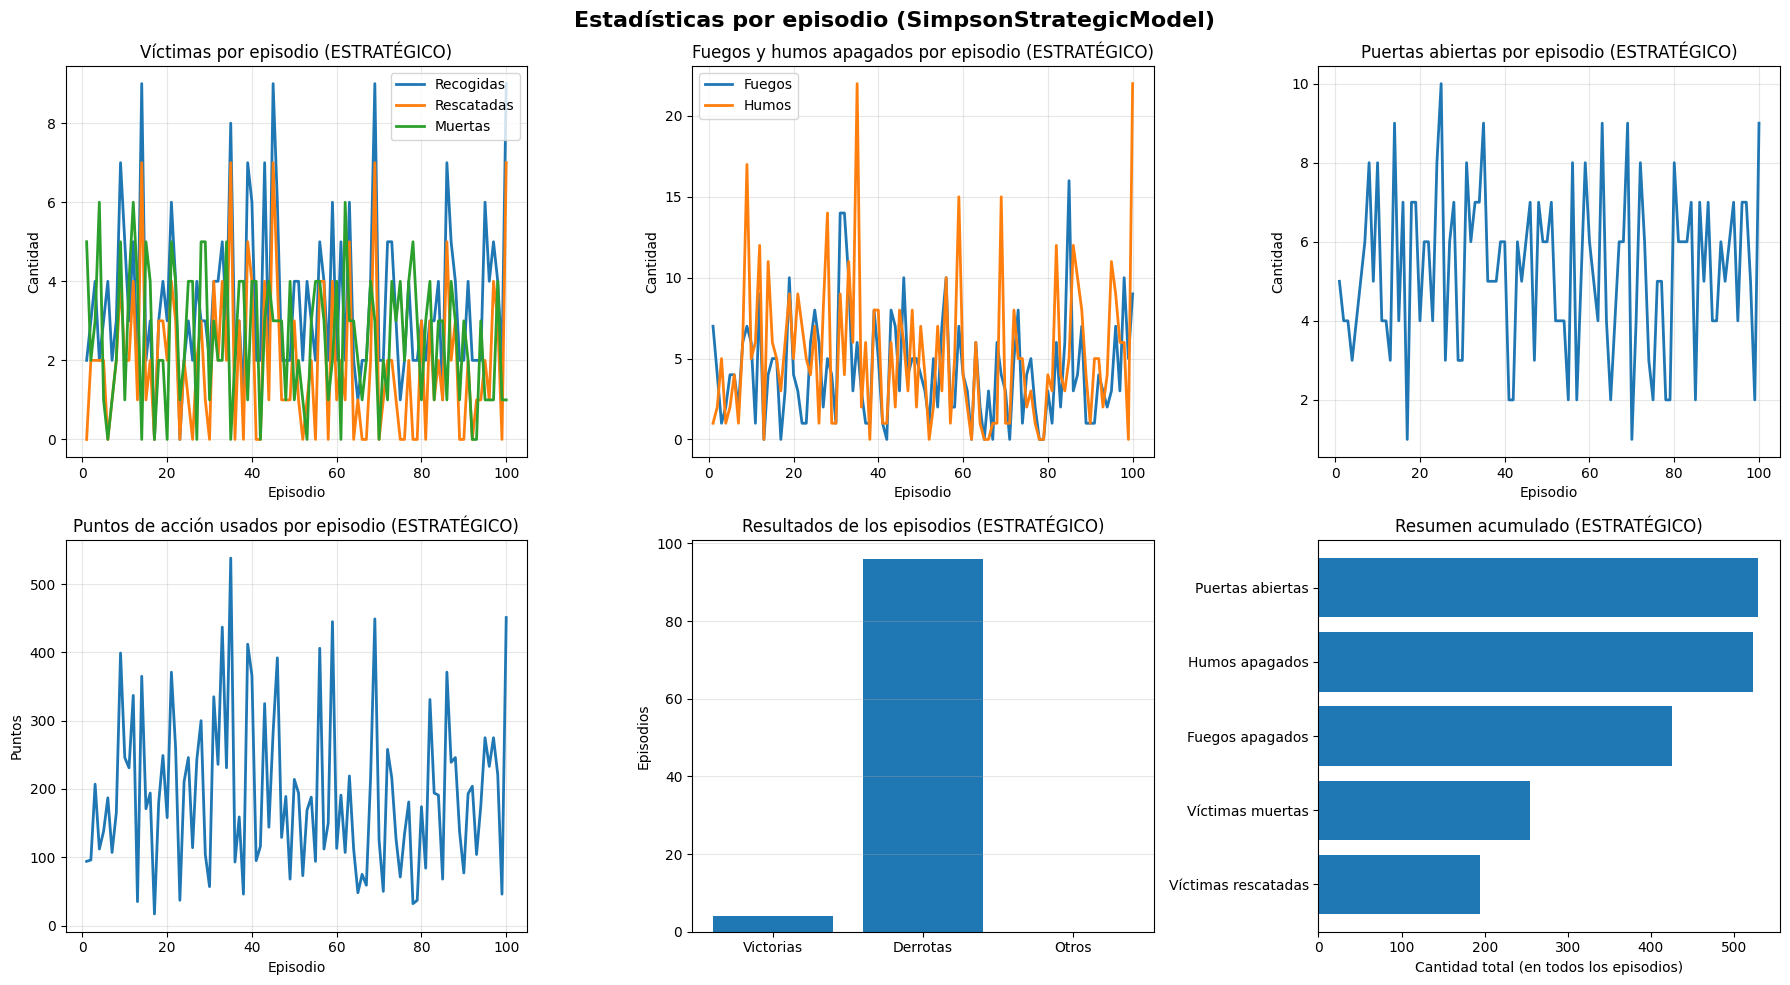

In [15]:
# Crear DataFrame a partir de la lista de episodios (ESTRATÉGICO)
episodios_df = pd.DataFrame(episodios_stats)
display(episodios_df.head())

print("=" * 60)
print("RESUMEN GLOBAL DE LOS", N_EPISODES, "EPISODIOS (ESTRATÉGICO)")
print("=" * 60)

wins = (episodios_df["game_result"] == "win").sum()
losses = (episodios_df["game_result"] == "lose").sum()
otros = N_EPISODES - wins - losses

print(f"Episodios jugados: {N_EPISODES}")
print(f"Victorias: {wins}")
print(f"Derrotas: {losses}")
print(f"Otros resultados: {otros}")
print()

# --------- MÉTRICAS QUE NOS INTERESAN ----------
metricas = [
    "total_victims_picked",
    "victims_rescued_total",
    "victims_dead_total",
    "total_fires_extinguished",
    "total_smokes_extinguished",
    "total_doors_opened",
    "total_action_points",
]

# --------- TOTALES GLOBALES (suma en todos los episodios) ----------
print("=" * 60)
print("TOTALES ACUMULADOS (TODOS LOS EPISODIOS) - ESTRATÉGICO")
print("=" * 60)

for m in metricas:
    print(f"{m}: {episodios_df[m].sum()}")

print()

# --------- PROMEDIOS GLOBALES ----------
print("=" * 60)
print("PROMEDIOS POR EPISODIO (TODOS LOS EPISODIOS) - ESTRATÉGICO")
print("=" * 60)

for m in metricas:
    print(f"{m} (promedio): {episodios_df[m].mean():.2f}")

print()

# --------- STATS SOLO DE PARTIDAS GANADAS ----------
wins_df = episodios_df[episodios_df["game_result"] == "win"]

print("=" * 60)
print("STATS SOLO DE EPISODIOS GANADOS - ESTRATÉGICO")
print("=" * 60)

if len(wins_df) == 0:
    print("No hubo victorias :(")
else:
    print(f"Episodios ganados: {len(wins_df)}\n")

    print("TOTALES ACUMULADOS (SOLO WINS):")
    for m in metricas:
        print(f"{m}: {wins_df[m].sum()}")
    print()

    print("PROMEDIOS POR EPISODIO (SOLO WINS):")
    for m in metricas:
        print(f"{m} (promedio): {wins_df[m].mean():.2f}")
    print()

# ==============================
# GRÁFICAS POR EPISODIO (ESTRATÉGICO)
# ==============================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Estadísticas por episodio (SimpsonStrategicModel)', fontsize=16, fontweight='bold')

# 1) Víctimas por episodio
axes[0, 0].plot(episodios_df["episodio"], episodios_df["total_victims_picked"], label='Recogidas', linewidth=2)
axes[0, 0].plot(episodios_df["episodio"], episodios_df["victims_rescued_total"], label='Rescatadas', linewidth=2)
axes[0, 0].plot(episodios_df["episodio"], episodios_df["victims_dead_total"], label='Muertas', linewidth=2)
axes[0, 0].set_xlabel('Episodio')
axes[0, 0].set_ylabel('Cantidad')
axes[0, 0].set_title('Víctimas por episodio (ESTRATÉGICO)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2) Fuegos / humos por episodio
axes[0, 1].plot(episodios_df["episodio"], episodios_df["total_fires_extinguished"], label='Fuegos', linewidth=2)
axes[0, 1].plot(episodios_df["episodio"], episodios_df["total_smokes_extinguished"], label='Humos', linewidth=2)
axes[0, 1].set_xlabel('Episodio')
axes[0, 1].set_ylabel('Cantidad')
axes[0, 1].set_title('Fuegos y humos apagados por episodio (ESTRATÉGICO)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3) Puertas abiertas por episodio
axes[0, 2].plot(episodios_df["episodio"], episodios_df["total_doors_opened"], linewidth=2)
axes[0, 2].set_xlabel('Episodio')
axes[0, 2].set_ylabel('Cantidad')
axes[0, 2].set_title('Puertas abiertas por episodio (ESTRATÉGICO)')
axes[0, 2].grid(True, alpha=0.3)

# 4) Puntos de acción por episodio
axes[1, 0].plot(episodios_df["episodio"], episodios_df["total_action_points"], linewidth=2)
axes[1, 0].set_xlabel('Episodio')
axes[1, 0].set_ylabel('Puntos')
axes[1, 0].set_title('Puntos de acción usados por episodio (ESTRATÉGICO)')
axes[1, 0].grid(True, alpha=0.3)

# 5) Resultados (win / lose / otros)
axes[1, 1].bar(['Victorias', 'Derrotas', 'Otros'], [wins, losses, otros])
axes[1, 1].set_ylabel('Episodios')
axes[1, 1].set_title('Resultados de los episodios (ESTRATÉGICO)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6) Resumen total (suma en todos los episodios)
resumen_total = {
    'Víctimas rescatadas': episodios_df['victims_rescued_total'].sum(),
    'Víctimas muertas': episodios_df['victims_dead_total'].sum(),
    'Fuegos apagados': episodios_df['total_fires_extinguished'].sum(),
    'Humos apagados': episodios_df['total_smokes_extinguished'].sum(),
    'Puertas abiertas': episodios_df['total_doors_opened'].sum()
}
axes[1, 2].barh(list(resumen_total.keys()), list(resumen_total.values()))
axes[1, 2].set_xlabel('Cantidad total (en todos los episodios)')
axes[1, 2].set_title('Resumen acumulado (ESTRATÉGICO)')

plt.tight_layout()
plt.show()

In [ ]:
import json
import logging
from http.server import BaseHTTPRequestHandler, HTTPServer

# =====================================================
#  CONFIGURACIÓN DE TIPOS DE PISO (LAYOUT FIJO)
#  - Usa las mismas celdas especiales que el modelo random,
#    pero ahora el modelo interno es SimpsonStrategicModel.
# =====================================================

KITCHEN_CELLS = set([
    (3,4), (3,3), (3,2),
    (4,4), (4,3), (4,2), (4,1), (3,1),
    (5,4), (5,3), (5,2), (5,1),
])

GARAGE_CELLS = set([
    (6,8), (6,7), (6,6), (6,5),
    (7,8), (7,7), (7,6), (7,5),
    (8,8), (8,7), (8,6), (8,5),
])

SAFE_CELLS = set([
    (0, 0),
])

SPAWN_CELLS = set([
    (2,9), (3,9), (4,9),
    (0,0), (1,0), (2,0),
    (9,3), (9,4), (9,5),
])

# =====================================================
#  CONFIGURACIÓN DE EPISODIOS MÚLTIPLES
# =====================================================

N_EPISODES = 100       # cuántas partidas van a correr
BASE_SEED = 0          # seed base; se irá incrementando

# Estado global
current_model = None
current_seed = BASE_SEED
episodes_played = 0
wins = 0
losses = 0
others = 0   # empates / estados raros

# Stats por episodio y totales acumulados
episode_stats_list = []

total_stats = {
    "victims_rescued": 0,
    "victims_picked": 0,
    "fires_extinguished": 0,
    "smokes_extinguished": 0,
    "doors_opened": 0,
    "action_points": 0,
}

# =====================================================
#  HELPERS PARA EXPORTAR ESTADO AL MUNDO EXTERNO (UNITY)
# =====================================================

def build_tiles_and_edges(model):
    """
    Construye:
      - tiles: lista de celdas con tipo semántico (kitchen, garage, inside, etc.)
      - edges: lista de paredes/puertas entre celdas adyacentes
    """
    width, height = model.width, model.height

    tiles = []
    for x in range(width):
        for y in range(height):
            pos = (x, y)
            if pos in KITCHEN_CELLS:
                t = "kitchen"
            elif pos in GARAGE_CELLS:
                t = "garage"
            elif pos in SAFE_CELLS:
                t = "safe"
            elif pos in SPAWN_CELLS:
                t = "spawn"
            else:
                t = "inside" if pos in model.inside_cells else "outside"
            tiles.append({"x": x, "y": y, "type": t})

    edges = []
    for x in range(width):
        for y in range(height):
            from_pos = (x, y)
            # Sólo generamos cada borde una vez (derecha y arriba)
            for dx, dy in ((1, 0), (0, 1)):  # derecha y arriba
                nx, ny = x + dx, y + dy
                if not (0 <= nx < width and 0 <= ny < height):
                    continue
                to_pos = (nx, ny)
                edge_type = model.edges.get((from_pos, to_pos), "empty")
                if edge_type == "wall":
                    e_type = "wall"
                elif edge_type == "door_closed":
                    e_type = "door_closed"
                elif edge_type == "door_open":
                    e_type = "door_open"
                else:
                    continue
                edges.append({
                    "ax": x, "ay": y,
                    "bx": nx, "by": ny,
                    "type": e_type,
                })

    return tiles, edges


def build_hazards(model):
    """
    Exporta la capa de fuego/humo como lista de:
      { "x":..., "y":..., "kind": "fire"|"smoke" }
    """
    hazards = []
    for x in range(model.width):
        for y in range(model.height):
            h = model.hazard_grid[x, y]
            if h == model.FIRE:
                hazards.append({"x": x, "y": y, "kind": "fire"})
            elif h == model.SMOKE:
                hazards.append({"x": x, "y": y, "kind": "smoke"})
    return hazards


def build_agents(model):
    """
    Exporta agentes para Unity:
      - id
      - posición
      - role (extinguisher/rescuer)
      - carrying_victim (bool)
    """
    agents = []
    for ag in model.schedule.agents:
        x, y = ag.pos
        agents.append({
            "id": int(ag.unique_id),
            "x": int(x),
            "y": int(y),
            "role": getattr(ag, "role", None),
            "carrying_victim": bool(getattr(ag, "carrying_victim", False)),
        })
    return agents


def build_victims(model):
    """
    Exporta víctimas vivas (victim_grid=True) como lista de {x,y}
    """
    victims = []
    for x in range(model.width):
        for y in range(model.height):
            if model.victim_grid[x, y]:
                victims.append({"x": x, "y": y})
    return victims


def build_full_state(model, include_tiles_edges=False):
    """
    Construye el payload JSON que mandamos a Unity en /floor y /step.
    """
    tiles, edges = ([], [])
    if include_tiles_edges:
        tiles, edges = build_tiles_and_edges(model)

    payload = {
        "width": model.width,
        "height": model.height,
        "tiles": tiles,
        "edges": edges,
        "hazards": build_hazards(model),
        "agents": build_agents(model),
        "victims": build_victims(model),
        "game_over": bool(model.game_over),
        "result": model.game_result,
    }
    return payload


def new_model(seed):
    """
    Crea un SimpsonStrategicModel nuevo con misma config que usas en Jupyter.
    """
    return SimpsonStrategicModel(
        width=10,
        height=10,
        num_firefighters=6,
        num_victims=4,
        seed=seed,
    )


def compute_episode_stats(model):
    """
    Suma los contadores de TODOS los agentes del modelo (para cada episodio).
    """
    stats = {
        "victims_rescued": 0,
        "victims_picked": 0,
        "fires_extinguished": 0,
        "smokes_extinguished": 0,
        "doors_opened": 0,
        "action_points": 0,
    }

    for ag in model.schedule.agents:
        stats["victims_rescued"]     += getattr(ag, "victims_rescued", 0)
        stats["victims_picked"]      += getattr(ag, "victims_picked", 0)
        stats["fires_extinguished"]  += getattr(ag, "fires_extinguished", 0)
        stats["smokes_extinguished"] += getattr(ag, "smokes_extinguished", 0)
        stats["doors_opened"]        += getattr(ag, "doors_opened", 0)
        stats["action_points"]       += getattr(ag, "action_points", 0)

    return stats

# =====================================================
#  HANDLER HTTP PARA UNITY (RUTAS /floor Y /step)
# =====================================================

class FloorHandler(BaseHTTPRequestHandler):
    def do_POST(self):
        global current_model, current_seed
        global episodes_played, wins, losses, others
        global episode_stats_list, total_stats

        # Leer body JSON (semilla opcional, etc.)
        length = int(self.headers.get("Content-Length", 0))
        raw = self.rfile.read(length) if length > 0 else b"{}"
        try:
            data = json.loads(raw.decode("utf-8"))
        except Exception:
            data = {}

        # -----------------------------------------
        #  /floor  → reinicia simulación multi-episodio
        # -----------------------------------------
        if self.path == "/floor":
            # Si mandas una seed desde Unity, úsala como base
            base_from_body = data.get("seed", None)
            if base_from_body is not None:
                BASE = int(base_from_body)
            else:
                BASE = BASE_SEED

            # reset de seeds, episodios y resultados
            current_seed = BASE
            episodes_played = 0
            wins = 0
            losses = 0
            others = 0

            # reset de stats
            episode_stats_list.clear()
            for k in total_stats:
                total_stats[k] = 0

            # primer modelo estratégico
            current_model = new_model(current_seed)

            layout = build_full_state(current_model, include_tiles_edges=True)
            # info extra de stats (Unity la ignora si no tiene campos)
            layout["episode"] = 1
            layout["wins"] = wins
            layout["losses"] = losses
            layout["others"] = others
            layout["current_seed"] = current_seed
            layout["max_episodes"] = N_EPISODES
            layout["simulation_done"] = False

            # totales en 0 al inicio
            layout["total_stats"] = total_stats
            layout["episode_finished"] = False
            layout["episode_stats"] = None

            resp_bytes = json.dumps(layout).encode("utf-8")
            self.send_response(200)
            self.send_header("Content-Type", "application/json")
            self.send_header("Content-Length", str(len(resp_bytes)))
            self.end_headers()
            self.wfile.write(resp_bytes)
            return

        # -----------------------------------------
        #  /step  → avanzar 1 turno del modelo estratégico
        # -----------------------------------------
        elif self.path == "/step":
            if current_model is None:
                self.send_response(400)
                self.end_headers()
                self.wfile.write(b'{"error": "No model. Call /floor first."}')
                return

            # Si ya jugamos todos los episodios, no avanzamos más
            if episodes_played >= N_EPISODES:
                state = build_full_state(current_model, include_tiles_edges=True)
                state["simulation_done"] = True
                state["episode"] = episodes_played
                state["wins"] = wins
                state["losses"] = losses
                state["others"] = others
                state["current_seed"] = current_seed
                state["max_episodes"] = N_EPISODES
                state["episode_finished"] = False
                state["episode_stats"] = None
                state["total_stats"] = total_stats

                resp_bytes = json.dumps(state).encode("utf-8")
                self.send_response(200)
                self.send_header("Content-Type", "application/json")
                self.send_header("Content-Length", str(len(resp_bytes)))
                self.end_headers()
                self.wfile.write(resp_bytes)
                return

            # Avanzar 1 paso en el episodio actual
            current_model.step()

            # Estado del tablero
            state = build_full_state(current_model, include_tiles_edges=True)

            # Por defecto, el episodio sigue
            state["episode_finished"] = False
            state["episode_stats"] = None
            state["simulation_done"] = False

            # Se terminó la partida actual?
            if current_model.game_over:
                result = getattr(current_model, "game_result", "")
                r_low = result.lower() if isinstance(result, str) else ""

                if ("win" in r_low) or ("victory" in r_low) or ("gan" in r_low):
                    wins += 1
                elif ("lose" in r_low) or ("derrota" in r_low) or ("perd" in r_low):
                    losses += 1
                else:
                    others += 1

                # --- stats de este episodio ---
                ep_stats = compute_episode_stats(current_model)
                episode_stats_list.append(ep_stats)
                for k, v in ep_stats.items():
                    total_stats[k] += v

                logging.info(f"Episode {episodes_played + 1} finished. Stats: {ep_stats}")
                logging.info(f"Total stats so far: {total_stats}")

                episodes_played += 1
                state["episode_finished"] = True
                state["episode_stats"] = ep_stats

                # Si todavía faltan episodios, creamos el siguiente modelo
                if episodes_played < N_EPISODES:
                    current_seed += 1
                    current_model = new_model(current_seed)
                else:
                    # ya no creamos más modelos; marcamos simulación terminada
                    state["simulation_done"] = True

            # episode index que se reporta:
            if current_model.game_over:
                # acabamos de terminar un episodio; el número es episodes_played
                episode_index = episodes_played
            else:
                # estamos dentro del episodio siguiente (episodes_played ya jugados)
                episode_index = episodes_played + 1

            # Añadimos stats globales al JSON (Unity los ignora si no los mapea)
            state["episode"] = episode_index
            state["wins"] = wins
            state["losses"] = losses
            state["others"] = others
            state["current_seed"] = current_seed
            state["max_episodes"] = N_EPISODES
            state["total_stats"] = total_stats

            resp_bytes = json.dumps(state).encode("utf-8")
            self.send_response(200)
            self.send_header("Content-Type", "application/json")
            self.send_header("Content-Length", str(len(resp_bytes)))
            self.end_headers()
            self.wfile.write(resp_bytes)
            return

        # -----------------------------------------
        #  cualquier otra ruta
        # -----------------------------------------
        self.send_response(404)
        self.end_headers()
        self.wfile.write(b"Not found")


def run(port=8585):
    """
    Lanza el servidor HTTP en el puerto indicado.
    Unity se conecta a:
      - POST /floor
      - POST /step
    """
    logging.basicConfig(level=logging.INFO)
    server_address = ("", port)
    httpd = HTTPServer(server_address, FloorHandler)
    logging.info(f"Starting http server on port {port}...\n")
    try:
        httpd.serve_forever()
    except KeyboardInterrupt:
        pass
    httpd.server_close()
    logging.info("Stopping http server...\n")


# Lanza el servidor en 8585 (puerto que usas en Unity)
run(8585)

INFO:root:Starting http server on port 8585...

INFO:root:Stopping http server...

